<a href="https://colab.research.google.com/github/AbigailUchennaNkama/model-drift-simulation/blob/master/embeddings_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Extracting image embeddings using a finetuned pretrained model

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torchvision import models
from joblib import dump
import torch.nn as nn
import torchvision.models

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from tqdm.auto import tqdm


In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

!git clone https://github.com/AbigailUchennaNkama/model-drift-simulation
!mv model-drift-simulation/model/cifar_model.pth .
!mv model-drift-simulation/drift_modules/get_data.py .
!rm -rf model-drift-simulation

Cloning into 'model-drift-simulation'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 251 (delta 50), reused 79 (delta 48), pack-reused 167
Receiving objects: 100% (251/251), 173.60 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (145/145), done.
Updating files: 100% (32/32), done.


In [3]:
!python get_data.py #get data

Using downloaded and verified file: ./cifar10.tgz 


In [4]:
model_pt = models.resnet18(weights='IMAGENET1K_V1')

In [5]:
# Print a summary using torchinfo
summary(model=model_pt,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

###Instantiate the pretrained resnet18 model

---



In [6]:
model = models.resnet18(weights='IMAGENET1K_V1')

# Modify the final fully connected layer for a new classification task (10 classes)
num_ftrs2 = model.fc.in_features
model.fc = nn.Linear(num_ftrs2, 10)

# Move the model to the desired device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state_dict (corrected position)
model.load_state_dict(torch.load("./cifar_model.pth", map_location=device))


<All keys matched successfully>

In [7]:
# Print a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torchvision import models
from joblib import dump
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to the input size expected by ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

def get_embeddings(model, data_path):

    '''' Example usage
    model = models.resnet18(pretrained=True)
    data_path = '/path/to/your/image/dataset'  # Replace with the actual path to image dataset
    embeddings, labels = get_embeddings(model, data_path)
    '''
    testset = torchvision.datasets.ImageFolder(data_path, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

    # Load pre-trained ResNet18 and remove the final classification layer
    model = model
    model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device) # Remove the last classification layer
    model.eval()

    # Extract embeddings
    embeddings, labels, img = [], [], []
    with torch.no_grad():
        for images, lbls in testloader:
            images, lbls = images.to(device), lbls.to(device)
            emb = model(images).squeeze(-1).squeeze(-1)  # After removing the last layer, there might be extra dimensions
            embeddings.append(emb)
            labels.append(lbls)

    embeddings = torch.cat(embeddings).cpu()
    labels = torch.cat(labels).cpu()

    # Save embeddings and labels
    dump(embeddings, f'embeddings.joblib')
    dump(labels, 'labels.joblib')

    return embeddings, labels




In [9]:
embeddings, labels = get_embeddings(model,'./data/cifar10/test')

In [10]:
from sklearn.manifold import TSNE
from joblib import load
import torch
loaded_labels = load('./labels.joblib')
loaded_embeddings = load('./embeddings.joblib')

type(loaded_embeddings)

torch.Tensor

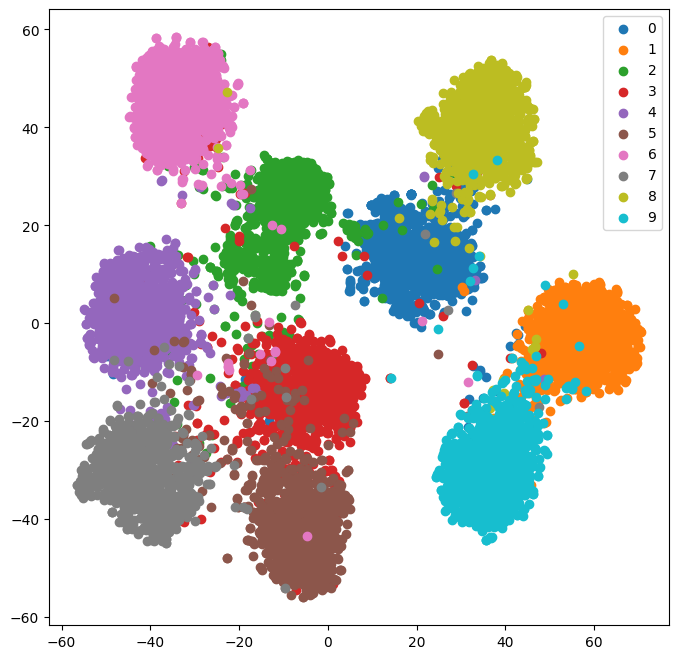

In [11]:
import matplotlib.pyplot as plt

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=0).fit_transform(loaded_embeddings)
#Save the t-SNE result
dump(tsne, 'tsne_embeddings.pkl')

class_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Plot the t-SNE reduced embeddings
plt.figure(figsize=(8, 8))
for i in range(10):
    indices = loaded_labels == i
    plt.scatter(tsne[indices, 0], tsne[indices, 1], label=str(i))
plt.legend()
plt.show()

In [12]:
pip install umap-learn

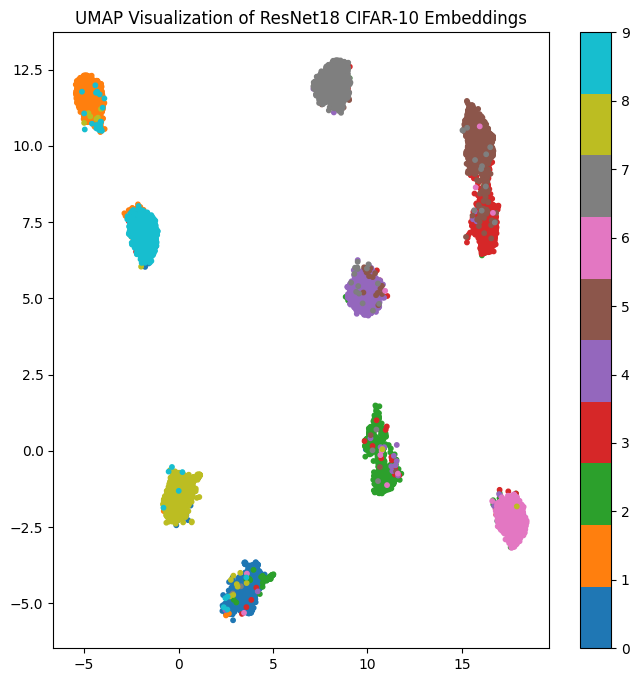

In [13]:
import umap
import matplotlib.pyplot as plt

# Use UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='correlation')
reduced_embeddings = umap_model.fit_transform(loaded_embeddings)

# Plot the UMAP visualization
plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=loaded_labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("UMAP Visualization of ResNet18 CIFAR-10 Embeddings")
plt.show()

#Train the model on 9 out of 10 classes of the cifar10 dataset

###**Get model and helper functions from github**

In [14]:
 # Get the going_modular scripts
print("[INFO] downloading helper functions from GitHub.")
!git clone https://github.com/AbigailUchennaNkama/model-drift-simulation
!mv model-drift-simulation/drift_modules/load_model.py .
!mv model-drift-simulation/drift_modules/get_data.py './data'
!mv model-drift-simulation/drift_modules/embeddings.py .
!mv model-drift-simulation/model .
!rm -rf model-drift-simulation

[INFO] downloading helper functions from GitHub.
Cloning into 'model-drift-simulation'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 251 (delta 50), reused 79 (delta 48), pack-reused 167
Receiving objects: 100% (251/251), 173.60 MiB | 30.16 MiB/s, done.
Resolving deltas: 100% (145/145), done.
Updating files: 100% (32/32), done.


##**Load cifar09 model**

In [15]:
#load pretrained model
from load_model import load_custom_pretrained_model
loaded_model_c9 = load_custom_pretrained_model(model_path='./model/cifar9_model_2.pth', num_classes=9)


In [16]:
# Print a summary using torchinfo
summary(model=loaded_model_c9,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 9]              --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

##Get test embeddings for all 10 classes from the cifar09 model

In [17]:
#Get embeddings from cifar09 model
embeddings_c9, labels_c9 = get_embeddings(loaded_model_c9,'./data/cifar10/test')

In [18]:
# Save embeddings and labels
torch.save(labels_c9, 'labels_c9.pt')
torch.save(embeddings_c9, 'embeddings_c9.pt')

In [19]:
# Load embeddings and labels
from sklearn.manifold import TSNE
from joblib import load
import torch

loaded_labels_c9 = torch.load('./labels_c9.pt')
loaded_embeddings_c9 = torch.load('./embeddings_c9.pt')

#**t-sne**

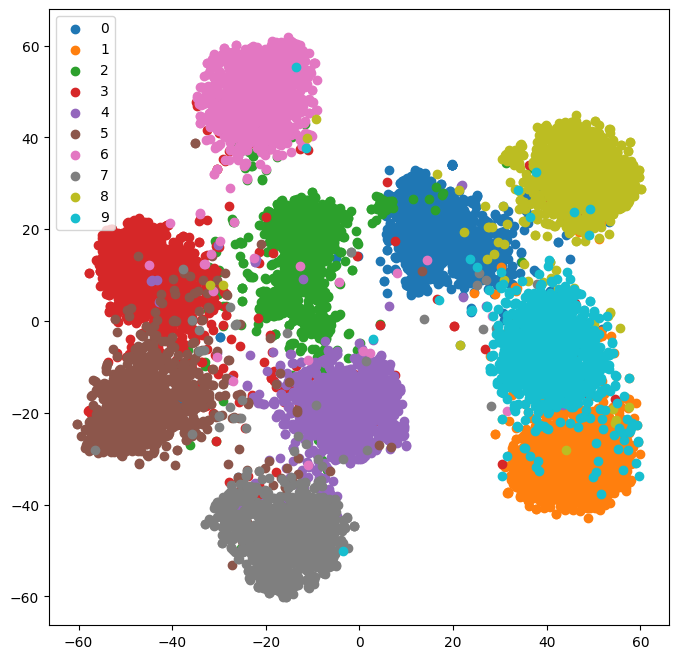

In [20]:
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=0).fit_transform(loaded_embeddings_c9)
# Plot the t-SNE reduced embeddings
plt.figure(figsize=(8, 8))
for i in range(10):
    indices = loaded_labels_c9 == i
    plt.scatter(tsne[indices, 0], tsne[indices, 1], label=str(i))
plt.legend()
plt.show()

#**umap**

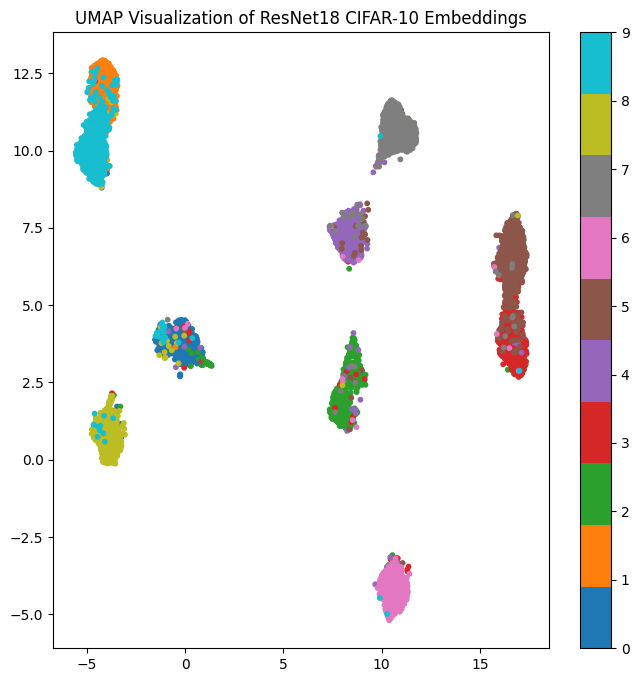

In [23]:
import umap
import matplotlib.pyplot as plt

# Use UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='correlation')
reduced_embeddings = umap_model.fit_transform(loaded_embeddings_c9)

# Plot the UMAP visualization
plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=loaded_labels_c9, cmap='tab10', s=10)
plt.colorbar()
plt.title("UMAP Visualization of ResNet18 CIFAR-10 Embeddings")
plt.show()

#**umap with plotly**

In [37]:
import umap
import plotly.express as px

# Use UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='correlation')
reduced_embeddings = umap_model.fit_transform(loaded_embeddings_c9)

# Map PyTorch tensor labels to class names
label_to_class = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# Convert PyTorch tensor labels to integers and then to class names
class_names = [label_to_class[label.item()] for label in loaded_labels_c9]

# Create a DataFrame for the UMAP data with class names
umap_df = pd.DataFrame({
    'UMAP_1': reduced_embeddings[:, 0],
    'UMAP_2': reduced_embeddings[:, 1],
    'Class': class_names  # Use class names for coloring
})

# Create a 2D scatter plot using Plotly
fig = px.scatter(
    umap_df,
    x='UMAP_1',
    y='UMAP_2',
    color='Class',  # Color by class names
    title='UMAP Visualization of ResNet18 CIFAR-10 Embeddings',
    labels={'Class': 'Class'},
    color_discrete_sequence=px.colors.qualitative.Set1  # Specify a color palette
)

fig.show()


#**Testing Cifar09 model on the test set with 10 classes**

The cifar09 model was trained on 9 out of 10 classes of the cifar10 dataset.

In [65]:
import pandas as pd
from tqdm.auto import tqdm
from torchvision import  transforms
import torch

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

from pathlib import Path

data_dir = "/content/data/cifar10/test"
test_data_paths = list(Path(data_dir).glob("*/*.png"))

# Define a dictionary to map class labels to class indices
class_to_index = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                  'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

class_names = ['airplane', 'automobile', 'bird', 'cat',
                  'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Inside the pred_and_store function
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        # Create empty dict to store info for each sample
        pred_dict = {}

        # Get sample path
        pred_dict["image_path"] = path

        # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Get the true label from test_labels
        #true_label = class_to_index[class_name]  # Use the class_to_index dictionary to get the true label


        # Get prediction and prediction probability
        from PIL import Image
        img = Image.open(path)  # open image
        transformed_image = transform(img).unsqueeze(0)  # transform image and add batch dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1).cpu()
            pred_class = class_names[pred_label.item()]
            true_label = class_to_index[class_name]

            # put things in the dictionary back on the CPU
            pred_dict["pred_prob"] = pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()  # Fix this line
            pred_dict["pred_class"] = pred_class
            pred_dict["pred_label"] = pred_label.item()
            pred_dict["true_label"] = true_label

        # Does the pred match the true label?
        pred_dict["correct"] = true_label == pred_label.item()
        # Add the dictionary to the list of preds
        test_pred_list.append(pred_dict)

    return test_pred_list, true_label, pred_label.item()


test_pred_dicts, true_label, pred_label = pred_and_store(test_paths=test_data_paths,
                                          model=loaded_model_c9,
                                          transform=manual_transforms,
                                          class_names=class_names,
                                          device=device)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
truck_pred = test_pred_df[test_pred_df["class_name"]=='truck']
truck_pred.tail()

,image_path,class_name,pred_prob,pred_class,pred_label,true_label,correct
5995,/content/data/cifar10/test/truck/0069.png,truck,0.623007,automobile,1,9,False
5996,/content/data/cifar10/test/truck/0760.png,truck,0.986674,automobile,1,9,False
5997,/content/data/cifar10/test/truck/0496.png,truck,0.998822,automobile,1,9,False
5998,/content/data/cifar10/test/truck/0209.png,truck,0.998952,automobile,1,9,False
5999,/content/data/cifar10/test/truck/0961.png,truck,0.509584,ship,8,9,False


In [67]:
truck_pred['pred_class'].value_counts()

automobile    811
airplane       96
ship           74
cat             7
horse           6
dog             3
bird            2
frog            1
Name: pred_class, dtype: int64

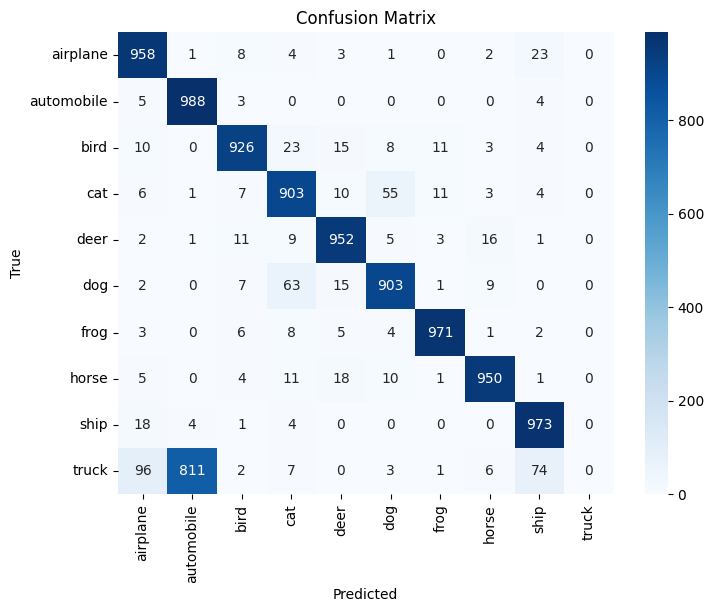

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels and predicted labels from test_pred_dicts
true_labels = [entry['true_label'] for entry in test_pred_dicts]
predicted_labels = [entry['pred_label'] for entry in test_pred_dicts]

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
